# Library

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt

from keras import models, layers

import json

import tensorflow as tf
from itertools import count

from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, stem_text
from gensim.utils import simple_preprocess, tokenize
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer

# Recommender System With Rating

In [ ]:
# Products Train
data = json.load(open('./data.json'))
train_data = data['train']

In [ ]:
business_id = []
user_id = []
rating = []
for tr in train_data :
    business_id.append(tr['business_id'])
    user_id.append(tr['user_id'])
    rating.append(tr['rating'])

In [ ]:
list_set = set(business_id)
unique_bId = (list(list_set))
list_set = set(user_id)
unique_uId = (list(list_set))

In [ ]:
def find_indexes(list_to_check, item_to_find) :
    return [indx for indx, value in enumerate(list_to_check) if value == item_to_find]

In [ ]:
DictUser = {}
DictBusiness = {}
for bId in unique_bId :
    indxs = find_indexes(business_id, bId)
    for indx in indxs :
        DictUser[user_id[indx] + '_' + business_id[indx]] = rating[indx]
        DictBusiness[business_id[indx] + '_' + user_id[indx]] = rating[indx]

In [ ]:
# Write dict
a_file = open("./dictionary_user.json", "w")
json.dump(DictUser, a_file)
a_file.close()

a_file = open("./dictionary_business.json", "w")
json.dump(DictBusiness, a_file)
a_file.close()

In [ ]:
# Read dict
DictUser = json.load(open('./dictionary_user.json'))

DictBusiness = json.load(open('./dictionary_business.json'))

In [ ]:
dictionary1 = sorted(DictUser)
sorted_dict_user = {key:DictUser[key] for key in dictionary1}

dictionary2 = sorted(DictBusiness)
sorted_dict_business = {key:DictBusiness[key] for key in dictionary2}

In [ ]:
embeddings_size = 128
usr, prd = len(user_id) - 1, len(business_id) - 1

######### Id #########
xusers_in1 = layers.Input(name="xusers_in1", shape=(1,))
xusers_emb = layers.Embedding(input_dim=prd, output_dim=embeddings_size)(xusers_in1)
xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)

xproducts_in1 = layers.Input(name="xproducts_in1", shape=(1,))
xproducts_emb = layers.Embedding(input_dim=usr, output_dim=embeddings_size)(xproducts_in1)
xproducts = layers.Reshape(name='xproducts', target_shape=(embeddings_size,))(xproducts_emb)

dot = layers.Dot(name='dot', normalize=True, axes=1)([xusers, xproducts])

######### Rate #########
xusers_in2 = layers.Input(name="xusers_in2", shape=(1,))
xproducts_in2 = layers.Input(name="xproducts_in2", shape=(1,))

concat1 = layers.Concatenate(name='concatenate1', axis=-1)([xusers_in2, xproducts_in2])

######### Out #########
concat2 = layers.Concatenate(name='concatenate2', axis=-1)([dot, concat1])

dense1 = layers.Dense(name="dense1", units=128, activation='linear')(concat2)
dense2 = layers.Dense(name="dense2", units=64, activation='linear')(dense1)
dense3 = layers.Dense(name="dense3", units=32, activation='linear')(dense2)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(dense3)

# Compile
model = models.Model(inputs=[xusers_in1, xproducts_in1, xusers_in2, xproducts_in2], outputs=y_out, name="NRS")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "NRS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in1 (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in1 (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       11137536    ['xusers_in1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       11137536    ['xproducts_in1[0][0]']          
                                                                                                

2023-02-09 23:24:31.009521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-09 23:24:31.009553: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (danial): /proc/driver/nvidia/version does not exist
2023-02-09 23:24:31.009849: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


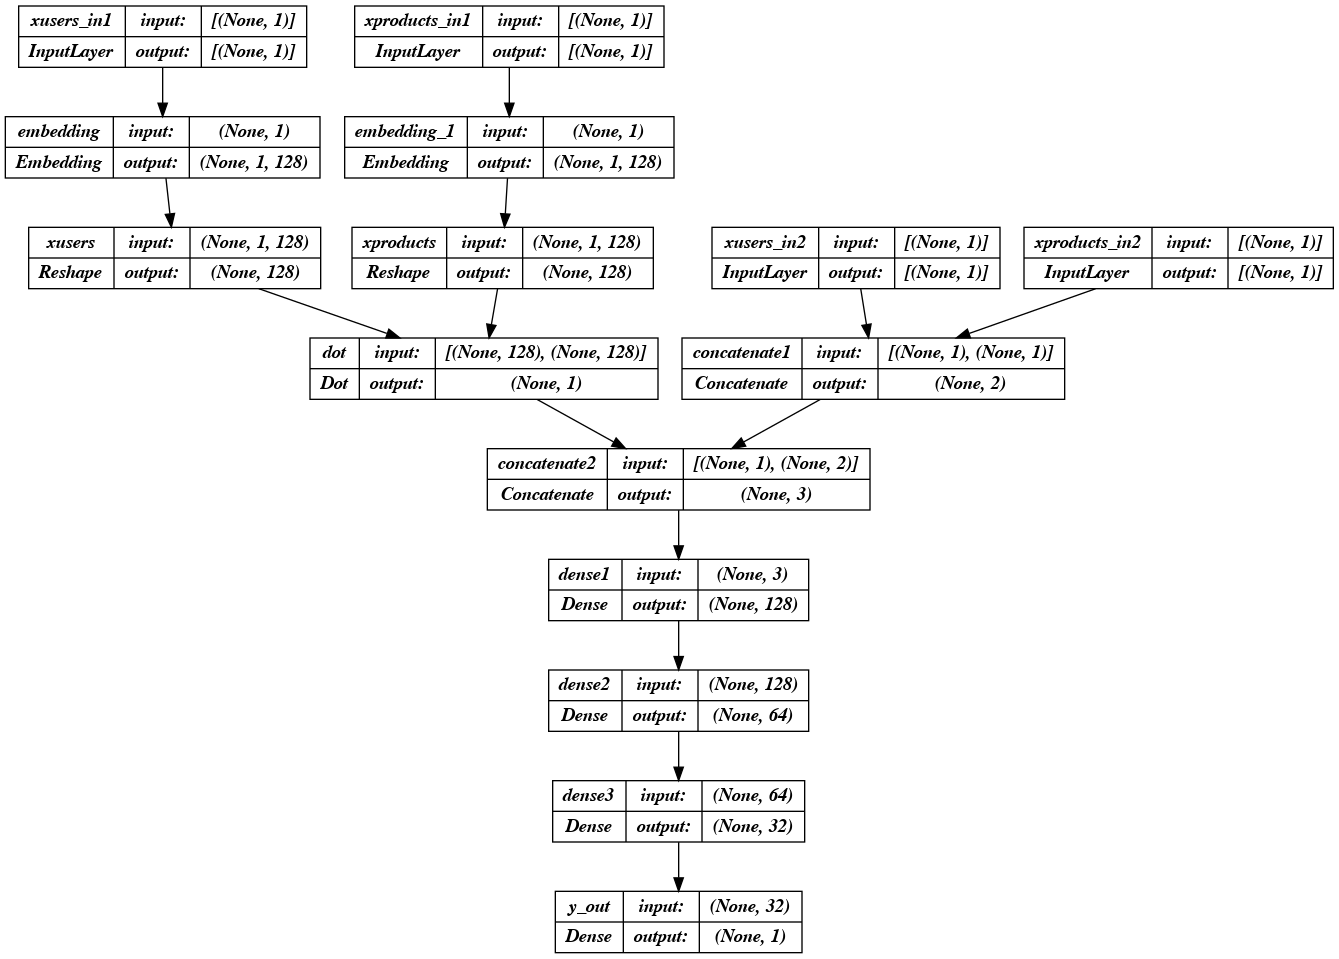

In [ ]:
tf.keras.utils.plot_model(model, to_file='model1.png', show_shapes=True, show_layer_names=True)

In [ ]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [ ]:
# Inputs
user_rating = []
business_rating = []
y = []

for i in range(len(user_id)) :
    sum = 0
    for j in range(len(business_id)) :
        if business_id[i] != business_id[j] :
            sum += rating[j]
    user_rating.append(sum)

for i in range(len(business_id)) :
    sum = 0
    for j in range(len(user_id)) :
        if user_id[i] != user_id[j] :
            sum += rating[j]
    business_rating.append(sum)


for rate in rating :
    if rate >= 3 :
        y.append(1)
    elif rate < 3 :
        y.append(0)

In [ ]:
# Write dict
a_file = open("./user_rating.json", "w")
json.dump(user_rating, a_file)
a_file.close()

a_file = open("./business_rating.json", "w")
json.dump(business_rating, a_file)
a_file.close()

a_file = open("./y.json", "w")
json.dump(y, a_file)
a_file.close()

In [ ]:
# Read dict
user_rating = json.load(open('./user_rating.json'))

business_rating = json.load(open('./business_rating.json'))

y = json.load(open('./y.json'))

In [ ]:
business_ids = list(map({}.setdefault, business_id, count()))
user_ids = list(map({}.setdefault, user_id, count()))

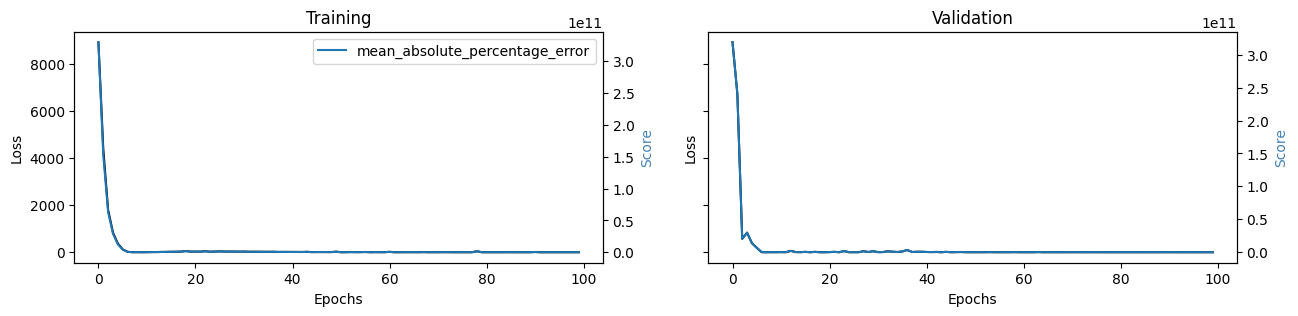

In [ ]:
# train
training = model.fit(x=[np.array(user_ids), np.array(business_ids), np.array(user_rating), np.array(business_rating)], y=np.array(y), 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
utils_plot_keras_training(training)

In [ ]:
model.save('./model')

INFO:tensorflow:Assets written to: ./model/assets


INFO:tensorflow:Assets written to: ./model/assets


In [ ]:
loaded_model = tf.keras.models.load_model('./model')

In [ ]:
np.save('./training.npy',training)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......concatenate_1
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dot
.........vars
......embedding
.........vars
............0
......embedding_1
.........vars
............0
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......input_layer_3
.........vars
......reshape
.........vars
......reshape_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........

Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-02-10 03:57:32           64
config.json                                    2023-02-10 03:57:32         5325
variables.h5                                   2023-02-10 03:57:32    267483672
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......concatenate
.........vars
......concatenate_1
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dot
.........vars
......embedding
.........vars
............0
......embedding_1
.........vars
............0
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......input_layer_3
.........vars
......reshape
.........vars
......resha

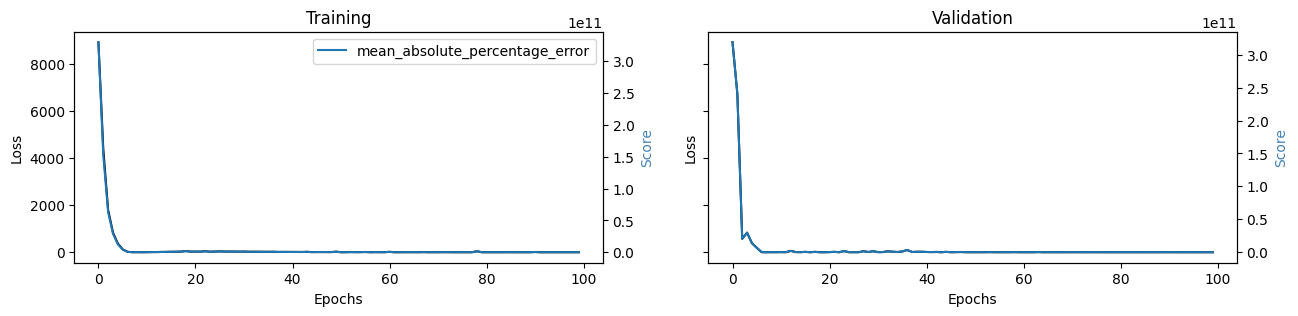

In [ ]:
loaded_training = np.load('./training.npy',allow_pickle='TRUE').item()
utils_plot_keras_training(loaded_training)

In [ ]:
# Products Test
tdata = json.load(open('./data.json'))
test_data = tdata['test']

In [ ]:
tbusiness_id = []
tuser_id = []
trating = []
for tt in test_data :
    tbusiness_id.append(tt['business_id'])
    tuser_id.append(tt['user_id'])
    trating.append(tt['rating'])

In [ ]:
list_set = set(tbusiness_id)
tunique_bId = (list(list_set))
list_set = set(tuser_id)
tunique_uId = (list(list_set))

In [ ]:
tDictUser = {}
tDictBusiness = {}
for bId in tunique_bId :
    indxs = find_indexes(tbusiness_id, bId)
    for indx in indxs :
        tDictUser[tuser_id[indx] + '_' + tbusiness_id[indx]] = trating[indx]
        tDictBusiness[tbusiness_id[indx] + '_' + tuser_id[indx]] = trating[indx]

In [ ]:
# Write dict
a_file = open("./tdictionary_user.json", "w")
json.dump(tDictUser, a_file)
a_file.close()

a_file = open("./tdictionary_business.json", "w")
json.dump(tDictBusiness, a_file)
a_file.close()

In [ ]:
# Read dict
tDictUser = json.load(open('./tdictionary_user.json'))

tDictBusiness = json.load(open('./tdictionary_business.json'))

In [ ]:
dictionary1 = sorted(tDictUser)
tsorted_dict_user = {key:tDictUser[key] for key in dictionary1}

dictionary2 = sorted(tDictBusiness)
tsorted_dict_business = {key:tDictBusiness[key] for key in dictionary2}

In [ ]:
# Inputs
tuser_rating = []
tbusiness_rating = []
ty = []

for i in range(len(tuser_id)) :
    sum = 0
    for j in range(len(tbusiness_id)) :
        if tbusiness_id[i] != tbusiness_id[j] :
            sum += trating[j]
    tuser_rating.append(sum)

for i in range(len(tbusiness_id)) :
    sum = 0
    for j in range(len(tuser_id)) :
        if tuser_id[i] != tuser_id[j] :
            sum += trating[j]
    tbusiness_rating.append(sum)


for rate in trating :
    if rate >= 3 :
        ty.append(1)
    elif rate < 3 :
        ty.append(0)

In [ ]:
# Write dict
a_file = open("./tuser_rating.json", "w")
json.dump(tuser_rating, a_file)
a_file.close()

a_file = open("./tbusiness_rating.json", "w")
json.dump(tbusiness_rating, a_file)
a_file.close()

a_file = open("./ty.json", "w")
json.dump(ty, a_file)
a_file.close()

In [ ]:
# Read dict
tuser_rating = json.load(open('./tuser_rating.json'))

tbusiness_rating = json.load(open('./tbusiness_rating.json'))

ty = json.load(open('./ty.json'))

In [ ]:
tbusiness_ids = list(map({}.setdefault, tbusiness_id, count()))
tuser_ids = list(map({}.setdefault, tuser_id, count()))

In [ ]:
# test
test = model.predict([np.array(tuser_ids), np.array(tbusiness_ids), np.array(tuser_rating), np.array(tbusiness_rating)])
test

345/345 [==============================] - 1s 1ms/step


array([[1.001667 ],
       [1.0016471],
       [1.0017071],
       ...,
       [1.0017704],
       [1.0016841],
       [1.0016474]], dtype=float32)

In [ ]:
np.save('./test.npy',test)

In [ ]:
loaded_test = np.load('./test.npy',allow_pickle='TRUE')

In [ ]:
accuracy = 0
precision = []
recall = []
for i in range(len(loaded_test)) :
    if np.round(loaded_test[i]) == ty[i] :
        accuracy += 1
        precision.append(accuracy / (i + 1))
        recall.append(accuracy / 10)

print('Accuracy : ' + str(np.round(accuracy / len(ty), 3) * 100) + '%')
print('Precision@5 : ' + str(np.round(precision[5], 2) * 100) + '%')
print('Recall@5 : ' + str(np.round(recall[5], 2) * 100) + '%')

Accuracy : 96.5%
Precision@5 : 100.0%
Recall@5 : 60.0%


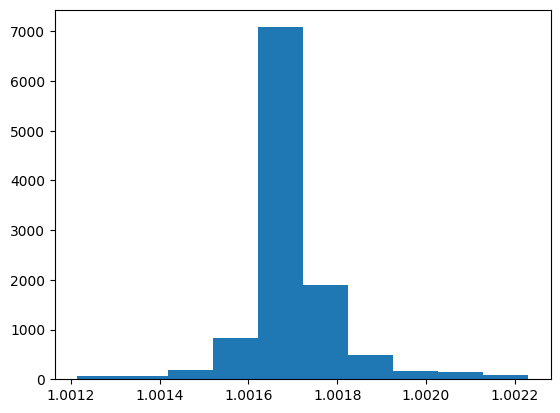

In [ ]:
plt.hist(loaded_test, bins=10)
plt.show()

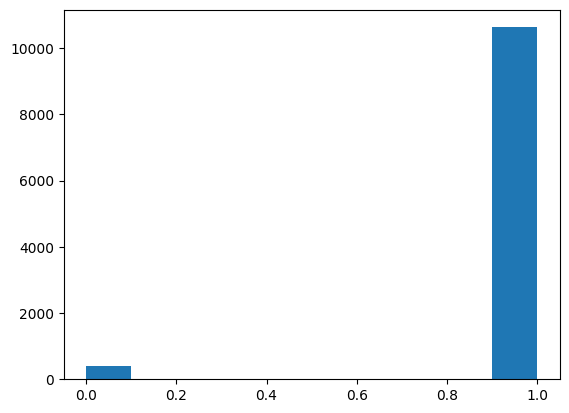

In [ ]:
plt.hist(ty, bins=10)
plt.show()

# Recommender System With Rating & Reviews

In [4]:
# Products Train
data = json.load(open('./data.json'))
train_data = data['train']

In [5]:
business_id = []
user_id = []
rating = []
history_reviews = {}
review_text = {}

for tr in train_data :
    business_id.append(tr['business_id'])
    user_id.append(tr['user_id'])
    rating.append(tr['rating'])
    review_text[tr['user_id'] + '_' + tr['business_id']] = tr['review_text']
    for review in tr['history_reviews'] :
        history_reviews[review[0]] = review[1]

In [4]:
review_texts = {**review_text, **history_reviews}
len(review_texts)

87013

In [5]:
list_set = set(business_id)
unique_bId = (list(list_set))
list_set = set(user_id)
unique_uId = (list(list_set))

In [6]:
def find_indexes(list_to_check, item_to_find) :
    return [indx for indx, value in enumerate(list_to_check) if value == item_to_find]

In [7]:
DictUser = {}
DictBusiness = {}
for bId in unique_bId :
    indxs = find_indexes(business_id, bId)
    for indx in indxs :
        DictUser[user_id[indx] + '_' + business_id[indx]] = rating[indx]
        DictBusiness[business_id[indx] + '_' + user_id[indx]] = rating[indx]

In [49]:
# Write dict
a_file = open("./dictionary_user2.json", "w")
json.dump(DictUser, a_file)
a_file.close()

a_file = open("./dictionary_business2.json", "w")
json.dump(DictBusiness, a_file)
a_file.close()

a_file = open("./dictionary_reviews.json", "w")
json.dump(review_texts, a_file)
a_file.close()

In [8]:
# Read dict
DictUser = json.load(open('./dictionary_user2.json'))

DictBusiness = json.load(open('./dictionary_business2.json'))

review_texts = json.load(open('./dictionary_reviews.json'))

In [10]:
dictionary1 = sorted(DictUser)
sorted_dict_user = {key:DictUser[key] for key in dictionary1}

dictionary2 = sorted(DictBusiness)
sorted_dict_business = {key:DictBusiness[key] for key in dictionary2}

In [9]:
embeddings_size = 128
usr, prd, rev = len(user_id) - 1, len(business_id) - 1, len(review_texts) - 1

############ Ids ############
xusers_in1 = layers.Input(name="xusers_in1", shape=(1,))
xusers_emb1 = layers.Embedding(input_dim=prd, output_dim=embeddings_size)(xusers_in1)
xusers1 = layers.Reshape(name='xusers1', target_shape=(embeddings_size,))(xusers_emb1)

xproducts_in1 = layers.Input(name="xproducts_in1", shape=(1,))
xproducts_emb1 = layers.Embedding(input_dim=usr, output_dim=embeddings_size)(xproducts_in1)
xproducts1 = layers.Reshape(name='xproducts1', target_shape=(embeddings_size,))(xproducts_emb1)

dot1 = layers.Dot(name='dot1', normalize=True, axes=1)([xusers1, xproducts1])

############ Reviews ############
xusers_in2 = layers.Input(name="xusers_in2", shape=(1,))

xproducts_in2 = layers.Input(name="xproducts_in2", shape=(1,))

concat1 = layers.Concatenate(name='concatenate1', axis=-1)([xusers_in2, xproducts_in2])

############ Rates ############
xusers_in3 = layers.Input(name="xusers_in3", shape=(1,))
xproducts_in3 = layers.Input(name="xproducts_in3", shape=(1,))

concat2 = layers.Concatenate(name='concatenate2', axis=-1)([xusers_in3, xproducts_in3])

############ Out ############
concat3 = layers.Concatenate(name='concatenate3', axis=-1)([dot1, concat1])
concat4 = layers.Concatenate(name='concatenate4', axis=-1)([concat2, concat3])

dense1 = layers.Dense(name="dense1", units=128, activation='linear')(concat4)
dense2 = layers.Dense(name="dense2", units=64, activation='linear')(dense1)
dense3 = layers.Dense(name="dense3", units=32, activation='linear')(dense2)
y_out = layers.Dense(name="y_out", units=1, activation='linear')(dense3)

# Compile
model = models.Model(inputs=[xusers_in1, xproducts_in1, xusers_in2, xproducts_in2, xusers_in3, xproducts_in3], outputs=y_out, name="NRS")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

2023-02-12 03:01:59.061390: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-12 03:01:59.061424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (danial): /proc/driver/nvidia/version does not exist
2023-02-12 03:01:59.061723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 03:01:59.078840: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 44550144 exceeds 10% of free system memory.
2023-02-12 03:01:59.107883: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 44550144 exceeds 10% of free system mem

Model: "NRS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in1 (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 xproducts_in1 (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       11137536    ['xusers_in1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       11137536    ['xproducts_in1[0][0]']          
                                                                                                

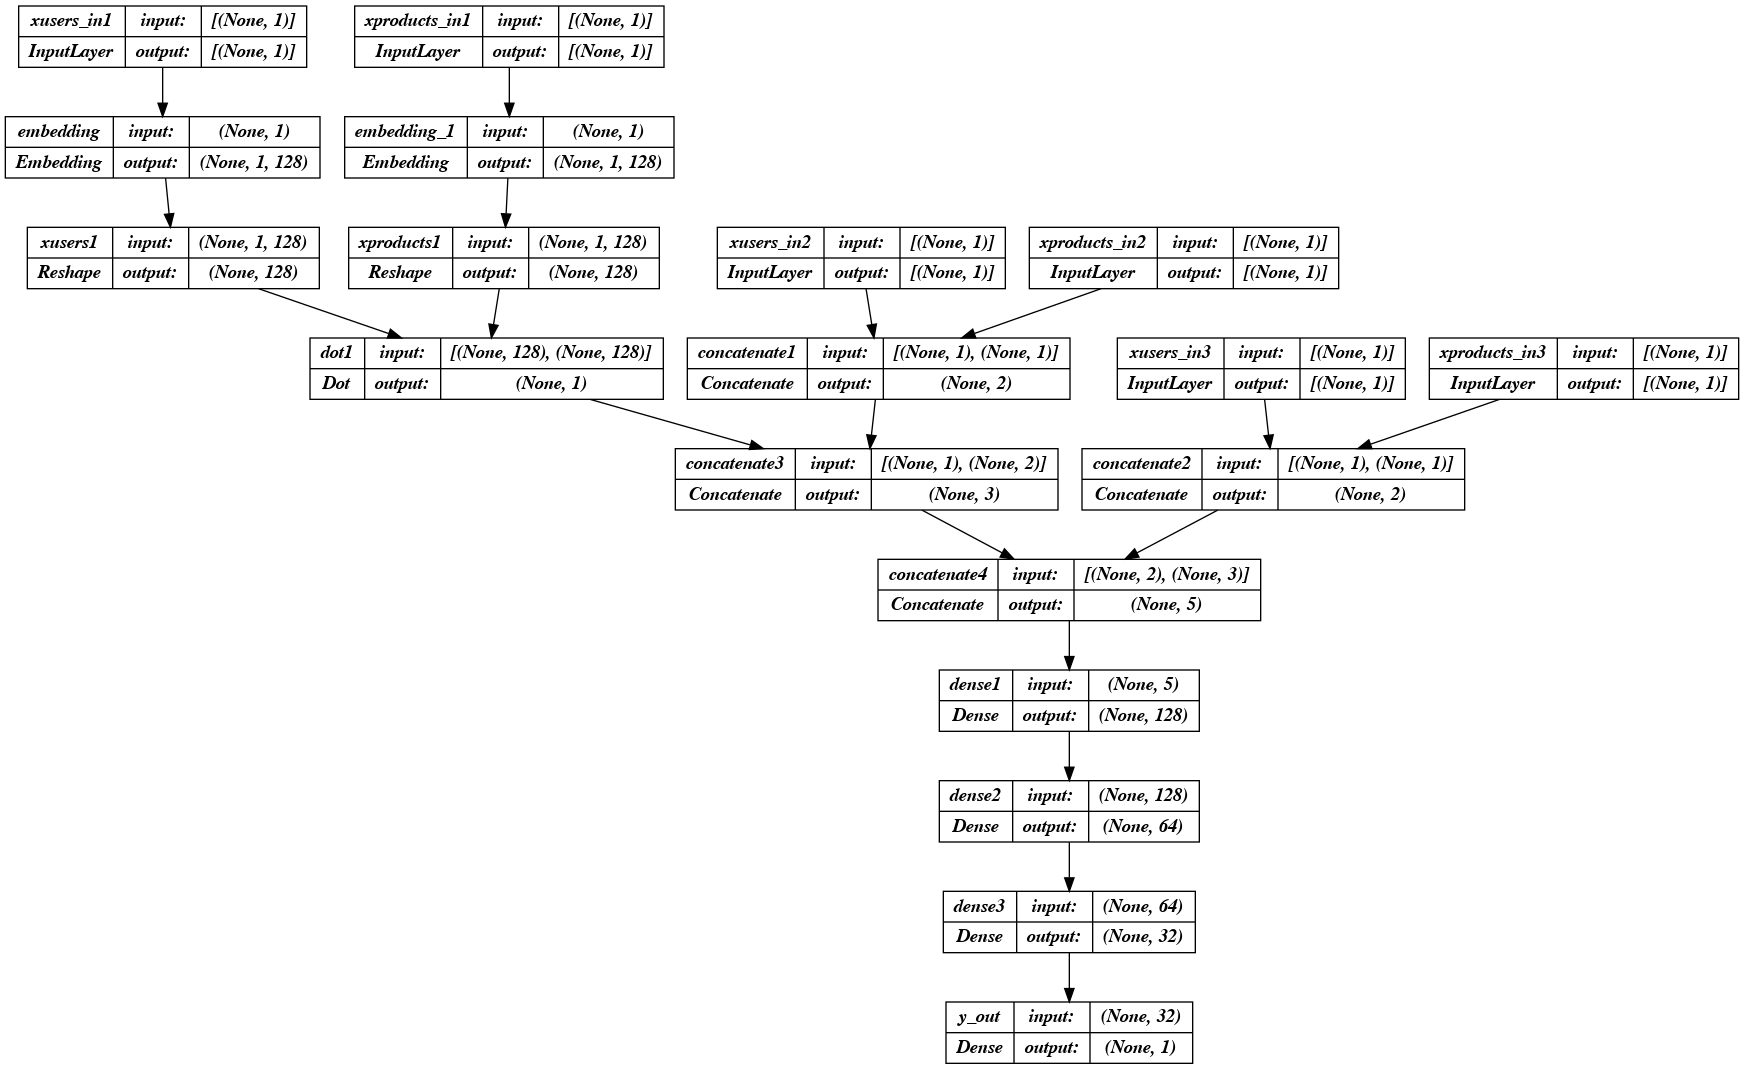

In [10]:
tf.keras.utils.plot_model(model, to_file='model2.png', show_shapes=True, show_layer_names=True)

In [52]:
'''
Plot loss and metrics of keras training.
'''
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [15]:
# Inputs
user_rating = []
business_rating = []
y = []

for i in range(len(user_id)) :
    sum = 0
    for j in range(len(business_id)) :
        if business_id[i] != business_id[j] :
            sum += rating[j]
    user_rating.append(sum)

for i in range(len(business_id)) :
    sum = 0
    for j in range(len(user_id)) :
        if user_id[i] != user_id[j] :
            sum += rating[j]
    business_rating.append(sum)


for rate in rating :
    if rate >= 3 :
        y.append(1)
    elif rate < 3 :
        y.append(0)

In [ ]:
# Write dict
a_file = open("./user_rating.json", "w")
json.dump(user_rating, a_file)
a_file.close()

a_file = open("./business_rating.json", "w")
json.dump(business_rating, a_file)
a_file.close()

a_file = open("./y.json", "w")
json.dump(y, a_file)
a_file.close()

In [49]:
# Read dict
user_rating = json.load(open('./user_rating.json'))

business_rating = json.load(open('./business_rating.json'))

y = json.load(open('./y.json'))

In [24]:
def remove_stop_words(document) :
    tokens = [list(tokenize(doc, lower=True)) for doc in document]
    tokens = [preprocess_string(" ".join(doc), [remove_stopwords, stem_text]) for doc in tokens]
    return tokens
    
def remove_stop_words2(sentences) :
    for i in range(len(sentences)) :
        sentences[i] = remove_stopwords(sentences[i].lower())
    
    return sentences

In [30]:
reviews_removed_stop = [remove_stopwords(x.lower()) for x in list(review_texts.values())]

In [31]:
EMBEDDING_DIM = 200

class ProcessedText:
    def __init__(self, text):
        self.text = text

    def __iter__(self):
        for line in self.text:
            yield simple_preprocess(line)
            
wv_model = Word2Vec(vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
wv_model.build_vocab(ProcessedText(reviews_removed_stop), update=False)
wv_model.train(ProcessedText(reviews_removed_stop), total_examples=wv_model.corpus_count, epochs=100)

print('Found %s word vectors of word2vec' % len(list(wv_model.wv.index_to_key)))

Found 30539 word vectors of word2vec


In [45]:
dictionary3 = sorted(review_texts)
sorted_dict_review = {key:review_texts[key] for key in dictionary3}

In [42]:
MAX_NB_WORDS = 90000

def embeddingMatrix(texts) :
    tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
    tokenizer.fit_on_texts(texts)
    word_index = tokenizer.word_index
    nb_words = min(MAX_NB_WORDS, len(word_index))+1

    embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
    for word, i in word_index.items():
        if word in list(wv_model.wv.index_to_key) :
            embedding_matrix[i] = wv_model.wv[word]

    return embedding_matrix

In [43]:
# Inputs
user_review = []
user_reviews_mean = []
business_review = []
business_reviews_mean = []

for i in range(len(user_id)) :
    revi = []
    for key in review_texts.keys() :
        if (user_id[i] == key.split('_')[0]) and (business_id[i] != key.split('_')[1]) :
            revi.append(review_texts[key])
    user_reviews_mean.append(np.mean(embeddingMatrix(revi)))
    user_review.append(revi)

for i in range(len(business_id)) :
    revi = []
    for key in review_texts.keys() :
        if (user_id[i] != key.split('_')[0]) and (business_id[i] == key.split('_')[1]) :
            revi.append(review_texts[key])
    business_reviews_mean.append(np.mean(embeddingMatrix(revi)))
    business_review.append(revi)

In [25]:
# user_review_remove = [remove_stop_words2(x) for x in user_review]
# business_review_remove = [remove_stop_words2(x) for x in business_review]

In [44]:
# Write dict
a_file = open("./user_review.json", "w")
json.dump(user_review, a_file)
a_file.close()

a_file = open("./user_reviews_mean.json", "w")
json.dump(user_reviews_mean, a_file)
a_file.close()

a_file = open("./business_review.json", "w")
json.dump(business_review, a_file)
a_file.close()

a_file = open("./business_reviews_mean.json", "w")
json.dump(business_reviews_mean, a_file)
a_file.close()

In [22]:
# Read dict
user_review = json.load(open('./user_review.json'))

user_reviews_mean = json.load(open('./user_reviews_mean.json'))

business_review = json.load(open('./business_review.json'))

business_reviews_mean = json.load(open('./business_reviews_mean.json'))

In [8]:
business_ids = list(map({}.setdefault, business_id, count()))
user_ids = list(map({}.setdefault, user_id, count()))

In [ ]:
# train
training = model.fit(x = [np.array(user_ids), np.array(business_ids), 
                    np.array(user_reviews_mean), np.array(business_reviews_mean), 
                    np.array(user_rating), np.array(business_rating)], 
                    y = np.array(y), 
                    epochs = 100, batch_size = 128, shuffle = True, verbose = 0, validation_split = 0.3)

model = training.model

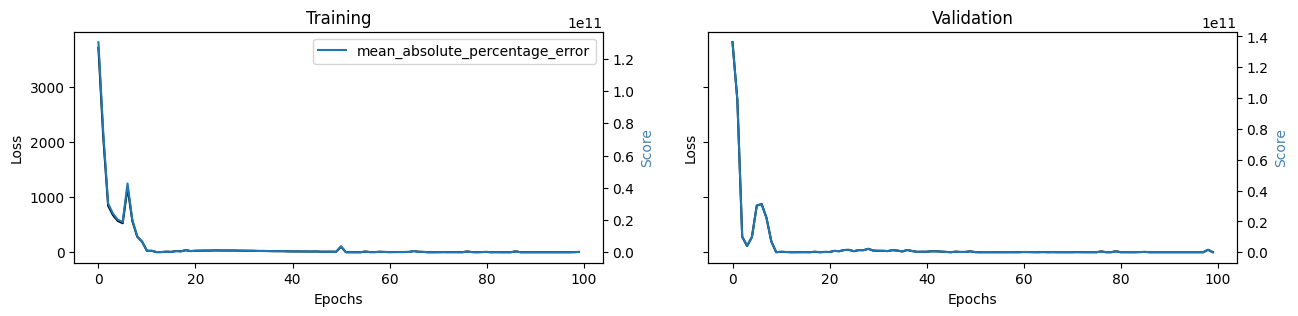

In [55]:
utils_plot_keras_training(training)

In [53]:
model.save('./model2')

INFO:tensorflow:Assets written to: ./model2/assets


INFO:tensorflow:Assets written to: ./model2/assets


In [ ]:
loaded_model = tf.keras.models.load_model('./model2')

In [54]:
np.save('./training2.npy',training)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......concatenate
.........vars
......concatenate_1
.........vars
......concatenate_2
.........vars
......concatenate_3
.........vars
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dot
.........vars
......embedding
.........vars
............0
......embedding_1
.........vars
............0
......input_layer
.........vars
......input_layer_1
.........vars
......input_layer_2
.........vars
......input_layer_3
.........vars
......input_layer_4
.........vars
......input_layer_5
.........vars
......reshape
.........vars
......reshape_1
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
....

In [ ]:
loaded_training = np.load('./training2.npy',allow_pickle='TRUE').item()
utils_plot_keras_training(loaded_training)

In [56]:
# Products Test
tdata = json.load(open('./data.json'))
test_data = tdata['test']

In [57]:
tbusiness_id = []
tuser_id = []
trating = []
thistory_reviews = {}
treview_text = {}

for tr in test_data :
    tbusiness_id.append(tr['business_id'])
    tuser_id.append(tr['user_id'])
    trating.append(tr['rating'])
    treview_text[tr['user_id'] + '_' + tr['business_id']] = tr['review_text']
    for review in tr['history_reviews'] :
        thistory_reviews[review[0]] = review[1]

In [ ]:
list_set = set(tbusiness_id)
tunique_bId = (list(list_set))
list_set = set(tuser_id)
tunique_uId = (list(list_set))

In [ ]:
tDictUser = {}
tDictBusiness = {}
for bId in tunique_bId :
    indxs = find_indexes(tbusiness_id, bId)
    for indx in indxs :
        tDictUser[tuser_id[indx] + '_' + tbusiness_id[indx]] = trating[indx]
        tDictBusiness[tbusiness_id[indx] + '_' + tuser_id[indx]] = trating[indx]

In [ ]:
# Write dict
a_file = open("./tdictionary_user2.json", "w")
json.dump(tDictUser, a_file)
a_file.close()

a_file = open("./tdictionary_business2.json", "w")
json.dump(tDictBusiness, a_file)
a_file.close()

In [ ]:
# Read dict
tDictUser = json.load(open('./tdictionary_user2.json'))

tDictBusiness = json.load(open('./tdictionary_business2.json'))

In [ ]:
dictionary1 = sorted(tDictUser)
tsorted_dict_user = {key:tDictUser[key] for key in dictionary1}

dictionary2 = sorted(tDictBusiness)
tsorted_dict_business = {key:tDictBusiness[key] for key in dictionary2}

In [ ]:
# Inputs
tuser_rating = []
tbusiness_rating = []
ty = []

for i in range(len(tuser_id)) :
    sum = 0
    for j in range(len(tbusiness_id)) :
        if tbusiness_id[i] != tbusiness_id[j] :
            sum += trating[j]
    tuser_rating.append(sum)

for i in range(len(tbusiness_id)) :
    sum = 0
    for j in range(len(tuser_id)) :
        if tuser_id[i] != tuser_id[j] :
            sum += trating[j]
    tbusiness_rating.append(sum)


for rate in trating :
    if rate >= 3 :
        ty.append(1)
    elif rate < 3 :
        ty.append(0)

In [ ]:
# Write dict
a_file = open("./tuser_rating2.json", "w")
json.dump(tuser_rating, a_file)
a_file.close()

a_file = open("./tbusiness_rating2.json", "w")
json.dump(tbusiness_rating, a_file)
a_file.close()

a_file = open("./ty_review.json", "w")
json.dump(ty, a_file)
a_file.close()

In [ ]:
# Read dict
tuser_rating = json.load(open('./tuser_rating2.json'))

tbusiness_rating = json.load(open('./tbusiness_rating2.json'))

ty = json.load(open('./ty_review.json'))

In [ ]:
treviews_removed_stop = [remove_stopwords(x.lower()) for x in list(treview_texts.values())]

In [ ]:
EMBEDDING_DIM = 200

class ProcessedText:
    def __init__(self, text):
        self.text = text

    def __iter__(self):
        for line in self.text:
            yield simple_preprocess(line)
            
twv_model = Word2Vec(vector_size=EMBEDDING_DIM, window=5, min_count=1, workers=4)
twv_model.build_vocab(ProcessedText(treviews_removed_stop), update=False)
twv_model.train(ProcessedText(treviews_removed_stop), total_examples=twv_model.corpus_count, epochs=100)

print('Found %s word vectors of word2vec' % len(list(twv_model.wv.index_to_key)))

Found 10973 word vectors of word2vec


In [ ]:
dictionary3 = sorted(treview_texts)
tsorted_dict_review = {key:treview_texts[key] for key in dictionary3}

In [ ]:
# Inputs
tuser_review = []
tuser_reviews_mean = []
tbusiness_review = []
tbusiness_reviews_mean = []

for i in range(len(tuser_id)) :
    revi = []
    for key in treview_texts.keys() :
        if (tuser_id[i] == key.split('_')[0]) and (tbusiness_id[i] != key.split('_')[1]) :
            revi.append(treview_texts[key])
    tuser_reviews_mean.append(np.mean(embeddingMatrix(revi)))
    tuser_review.append(revi)

for i in range(len(tbusiness_id)) :
    revi = []
    for key in treview_texts.keys() :
        if (tuser_id[i] != key.split('_')[0]) and (tbusiness_id[i] == key.split('_')[1]) :
            revi.append(treview_texts[key])
    tbusiness_reviews_mean.append(np.mean(embeddingMatrix(revi)))
    tbusiness_review.append(revi)

In [ ]:
tuser_review_remove = [remove_stop_words2(x) for x in tuser_review]
tbusiness_review_remove = [remove_stop_words2(x) for x in tbusiness_review]

In [ ]:
# Write dict
a_file = open("./tuser_review.json", "w")
json.dump(tuser_review, a_file)
a_file.close()

a_file = open("./tuser_reviews_mean.json", "w")
json.dump(tuser_reviews_mean, a_file)
a_file.close()

a_file = open("./tbusiness_review.json", "w")
json.dump(tbusiness_review, a_file)
a_file.close()

a_file = open("./tbusiness_reviews_mean.json", "w")
json.dump(tbusiness_reviews_mean, a_file)
a_file.close()

In [ ]:
# Read dict
tuser_review = json.load(open('./tuser_review.json'))

tuser_reviews_mean = json.load(open('./tuser_reviews_mean.json'))

tbusiness_review = json.load(open('./tbusiness_review.json'))

tbusiness_reviews_mean = json.load(open('./tbusiness_reviews_mean.json'))


In [ ]:
tbusiness_ids = list(map({}.setdefault, tbusiness_id, count()))
tuser_ids = list(map({}.setdefault, tuser_id, count()))

In [ ]:
# test
test = model.predict([np.array(tuser_ids), np.array(tbusiness_ids), 
                    np.array(tuser_reviews_mean), np.array(tbusiness_reviews_mean), 
                    np.array(tuser_rating), np.array(tbusiness_rating)])
test

345/345 [==============================] - 1s 1ms/step


array([[0.9385554 ],
       [0.9385655 ],
       [0.93844706],
       ...,
       [0.93819016],
       [0.93848777],
       [0.93861485]], dtype=float32)

In [ ]:
np.save('./test2.npy',test)

In [ ]:
loaded_test = np.load('./test2.npy',allow_pickle='TRUE')

In [ ]:
accuracy = 0
precision = []
recall = []
for i in range(len(loaded_test)) :
    if np.round(loaded_test[i]) == ty[i] :
        accuracy += 1
        precision.append(accuracy / (i + 1))
        recall.append(accuracy / 10)

print('Accuracy : ' + str(np.round(accuracy / len(ty), 3) * 100) + '%')
print('Precision@5 : ' + str(np.round(precision[5], 2) * 100) + '%')
print('Recall@5 : ' + str(np.round(recall[5], 2) * 100) + '%')

Accuracy : 96.5%
Precision@5 : 100.0%
Recall@5 : 60.0%


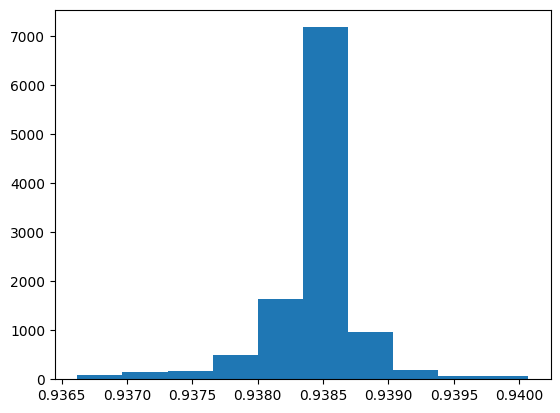

In [ ]:
plt.hist(loaded_test, bins=10)
plt.show()

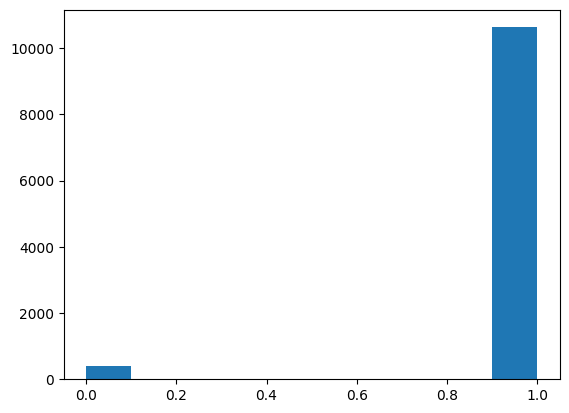

In [ ]:
plt.hist(ty, bins=10)
plt.show()